In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.layers import Conv2D,Input,LeakyReLU,Dense,Activation,Flatten,Dropout,MaxPool2D
from keras import models
#from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras.optimizers   
import time
from keras.optimizer_v2  import adam,rmsprop  #不同版本的keras
import tensorflow
import platform 

print("python版本："+platform.python_version())
print("keras版本"+keras.__version__)
print(tensorflow.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
python版本：3.9.2
keras版本2.5.0
2.5.0-rc0


In [2]:
np.random.seed(520)
io="D:\\_dataset\\rock_label_1.csv"
data = pd.read_csv(io,encoding='GBK')
alist=data.values[0::,1]
labellist={'浅灰色细砂岩':0, '深灰色粉砂质泥岩':1, '黑色煤':2, '灰色泥质粉砂岩':3, '灰色细砂岩':4, '深灰色泥岩':5, '灰黑色泥岩':6}
#7分类

亮度归一化

In [3]:
#亮度归一化
def Liangduguiyi(image):
    m_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    Gamma = np.log(128.0 / 255.0) / np.log(cv2.mean(m_gray)[0] / 255.0)
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, Gamma) * 255.0, 0, 255)
    image = cv2.LUT(image, lookUpTable)
    return image

In [4]:
r_width,r_height=112,112

rock_sample_data='D:\_dataset\Data_all'
files = os.listdir(rock_sample_data)
images=[]
images_norm=[]
label=[]
count=[0,0,0,0,0,0,0]
number=0
for img in files:     
    full_path=rock_sample_data+"/"+img
    #img = Liangduguiyi(cv2.imread(full_path))   #亮度归一化
    img = cv2.imread(full_path)
    #img = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)   #单通道
    #img=cv2.normalize(img,dst=None,alpha=350,beta=10,norm_type=cv2.NORM_MINMAX)   #预处理，增强图像对比度
    #images.append(cv2.cvtColor(cv2.resize(img,(r_width,r_height),interpolation=cv2.INTER_NEAREST),cv2.COLOR_GRAY2BGR))#三通道，缩小图片到112*112
    images.append(cv2.resize(img,(r_width,r_height),interpolation=cv2.INTER_NEAREST))   #缩小图片到r_width*r_height
    i=eval(full_path[-5])
    label.append(i)
    count[i]+=1
    number+=1
   

In [5]:
X=np.array(images)/255   #对数据除以255，cnn模型对数值小的数处理得比较好
X=X.astype(np.float64)   #转换数据格式,图像格式为np.uint8, 转换成float型，计算机可以计算
Y=np.array(label)
from keras.utils.np_utils import to_categorical  #2.5.0版本的得换成这个...
#from keras import utils 
#Y=to_categorical(Y,7)   #多分类问题得在打乱数据前对Y进行one-hot化

整理，打乱数据集；分离到训练集和测试机

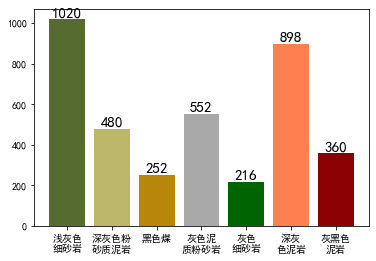

[1020, 480, 252, 552, 216, 898, 360]
<class 'numpy.number'>


In [6]:
from pylab import *
from matplotlib.font_manager import FontProperties 

def cnt_label(label):
    count=[0,0,0,0,0,0,0]
    for i in range(len(label)):
        count[label[i]]+=1
    return count    
    


def print_count(count):
    mpl.rcParams['font.sans-serif'] = ['SimHei']
    labellist={'浅灰色细砂岩':0, '深灰色粉砂质泥岩':1, '黑色煤':2, '灰色泥质粉砂岩':3, '灰色细砂岩':4, '深灰色泥岩':5, '灰黑色泥岩':6}
    name=['浅灰色\n细砂岩', '深灰色粉\n砂质泥岩', '黑色煤', '灰色泥\n质粉砂岩', '灰色\n细砂岩', '深灰\n色泥岩', '灰黑色\n泥岩']
    rects=plt.bar(range(len(count)),count,tick_label=name,color=['darkolivegreen','darkkhaki','darkgoldenrod','darkgray','darkgreen','coral','darkred'])
    for rect in rects:  #rects 是三根柱子的集合
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')

    plt.show() 
    print(count)
    print(number)
    
print_count(count)

In [7]:
print(sum(count))

3778


In [8]:
num_example = len(images)
print("数量:")
print(num_example)
arr=[]

dir_dataset_file="D:\\_dataset\\trained_models\\dataset_file.txt"
if os.path.exists(dir_dataset_file)==True:  #读取数据集文件   
    with open(dir_dataset_file) as lines:
        for line in lines:
            arr.append(eval(line))
    print("已读取文件上的数据集")
else:
    arr = np.arange(num_example)   #数据集文件不存在，创建数据集并打乱
    np.random.shuffle(arr)# 调用函数，打乱顺序
    
    

dat=X[arr]
data_label=Y[arr]
ratio = 0.8
s = np.int(num_example * ratio)
ss = np.int(num_example *  (ratio+0.1))

x_train = dat[:s]
y_train = data_label[:s]
x_val = dat[s:ss]
y_val = data_label[s:ss]
x_test = dat[ss:]
y_test = data_label[ss:]

#print(data_label)
print(X.shape)
print(Y.shape)



数量:
3778
已读取文件上的数据集
(3778, 112, 112, 3)
(3778,)


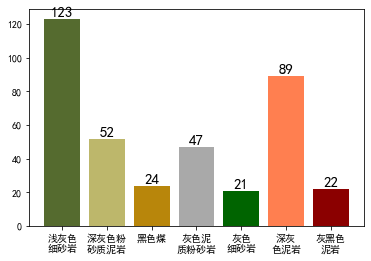

[123, 52, 24, 47, 21, 89, 22]
<class 'numpy.number'>
378


In [9]:
t=cnt_label(y_test)
print_count(t)
print(sum(t))

In [10]:
print(y_train)

[2 0 3 ... 1 0 0]


In [11]:
#Y=to_categorical(Y,7)
print(type(Y))
#print(Y)

y_test=to_categorical(y_test,7)   #多分类问题得在打乱数据前对Y进行one-hot化
y_train=to_categorical(y_train,7)
y_val=to_categorical(y_val,7)
print(type(y_val))
#print(y_val)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
print(x_train.shape)
print("矩阵总大小:")
print(len(x_train)*len(x_train[0])*len(x_train[0][0])*len(x_train[0][0][0]))


(3022, 112, 112, 3)
矩阵总大小:
113723904


随机访问一个数据并绘图，查看数据处理结果

下图显示的是：浅灰色细砂岩
<class 'numpy.ndarray'>
0


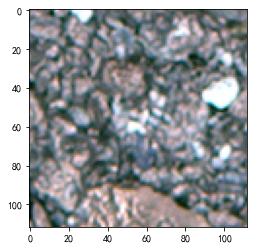

In [13]:
labellist_=['浅灰色细砂岩', '深灰色粉砂质泥岩', '黑色煤', '灰色泥质粉砂岩', '灰色细砂岩', '深灰色泥岩', '灰黑色泥岩']
#print(len(x_train))
import matplotlib.pyplot as plt
import random
rand=random.randint(0,len(X))

imagedemo = X[rand]
imagedemolabel = label[rand]
plt.imshow(imagedemo)
print("下图显示的是："+labellist_[imagedemolabel])
print(type(imagedemo))
print(imagedemolabel)


In [14]:
'''
img_norm=cv2.normalize(imagedemo,dst=None,alpha=350,beta=10,norm_type=cv2.NORM_MINMAX)/255   #预处理，增强图像对比度
plt.imshow(img_norm)
print("下图显示的是增强对比度的图片：")
#print(imagedemo)
#print(img_norm)'''

'\nimg_norm=cv2.normalize(imagedemo,dst=None,alpha=350,beta=10,norm_type=cv2.NORM_MINMAX)/255   #预处理，增强图像对比度\nplt.imshow(img_norm)\nprint("下图显示的是增强对比度的图片：")\n#print(imagedemo)\n#print(img_norm)'

keras数据增强有两个办法  
1.使用flow产生一个迭代器  
2.对文件保存路径使用.flow_from_directory(directory)，可以直接训练

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D,Input,LeakyReLU,Dense,Activation,Flatten,Dropout,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import models


#模型的建立
def define_model():
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     padding='same',
                     input_shape=(r_width, r_height, 3),
                     activation='relu'))  # 卷积层1

    model.add(MaxPooling2D(pool_size=(2, 2)))  # 池化层2
    #model.add(BatchNormalization(axis=-1))  #添加BN层将上一层的数据标准化，利于避开激励函数的饱和区
    CLASS=7
    DROPOUT_RATE=0.2

    #再次构建一个卷积层
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    #构建一个池化层，提取特征，池化层的池化窗口为2*2，步长为2。
    model.add(MaxPool2D(pool_size=(3, 3),strides=1))
    #继续构建卷积层和池化层，区别是卷积核数量为64。
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(Dropout(DROPOUT_RATE)) #加入dropout，防止过拟合。
    model.add(MaxPool2D(pool_size=(3, 3),strides=1))
    
    '''
    #继续构建卷积层和池化层，区别是卷积核数量为128。
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
    #model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(Dropout(DROPOUT_RATE)) #加入dropout，防止过拟合。
    model.add(MaxPool2D(pool_size=(2, 2), strides=1))
    '''

    model.add(Flatten()) #数据扁平化
    model.add(Dense(128,activation='relu')) #构建一个具有128个神经元的全连接层
    model.add(Dense(64,activation='relu')) #构建一个具有64个神经元的全连接层
    model.add(Dropout(DROPOUT_RATE)) #加入dropout，防止过拟合。
    model.add(Dense(CLASS,activation='softmax')) #输出层，一共7个神经元，对应7个分类
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

数据增强处理

In [16]:


#训练集数据增强处理
datagen = ImageDataGenerator(
    rotation_range = 2,     # 随机旋转度数
    width_shift_range = 0.20, # 随机水平平移
    height_shift_range = 0.20,# 随机竖直平移
    #rescale = 1/255,         # 数据归一化
    shear_range = 10,       # 随机错切变换
    zoom_range = 0.20,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    fill_mode = 'wrap',   # 填充方式
)



查看处理后的图片

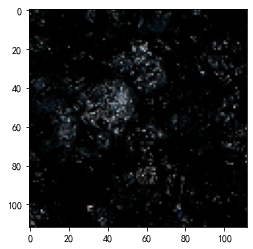

In [24]:
temp=x_train[0:1]
plt.imshow(temp[0])

(1, 112, 112, 3)


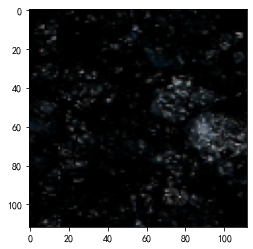

In [31]:

print(temp.shape)
for batch in datagen.flow(temp, batch_size=1):
    plt.imshow(batch[0])
    i += 1
    if i > 2:
        break  # otherwise the generator would loop indefinitel

95


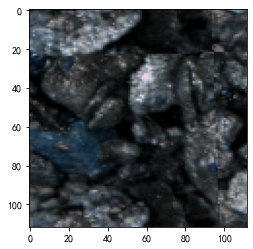

In [15]:

data_it=datagen.flow(x_train, y_train, batch_size=32)
print(data_it)
print(len(data_it))

i = 0
for batch in datagen.flow(x_train, batch_size=2):
    plt.imshow(batch[0])
    i += 1
    if i > 2:
        break  # otherwise the generator would loop indefinitel


#plt.imshow(imagedemo)

开始训练

In [75]:
from keras.applications import vgg19
from keras import layers,optimizers

In [17]:
print(keras.optimizer_v2.adam)

<module 'keras.optimizer_v2.adam' from 'C:\\Users\\Chei\\AppData\\Roaming\\Python\\Python39\\site-packages\\keras\\optimizer_v2\\adam.py'>


In [59]:
from keras.applications.densenet import DenseNet169
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model

In [60]:
help(keras.applications.inception_v3 )

Help on module keras.applications.inception_v3 in keras.applications:

NAME
    keras.applications.inception_v3 - Inception V3 model for Keras.

DESCRIPTION
    Reference:
      - [Rethinking the Inception Architecture for Computer Vision](
          http://arxiv.org/abs/1512.00567) (CVPR 2016)

FUNCTIONS
    InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')
        Instantiates the Inception v3 architecture.
        
        Reference:
        - [Rethinking the Inception Architecture for Computer Vision](
            http://arxiv.org/abs/1512.00567) (CVPR 2016)
        
        This function returns a Keras image classification model,
        optionally loaded with weights pre-trained on ImageNet.
        
        For image classification use cases, see
        [this page for detailed examples](
          https://keras.io/api/applications/#usage-examples-for-image-classification-models).


In [63]:
#from keras.utils import  plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [76]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" #调用GPU
''''''
net = vgg19.VGG19(include_top=False,weights='imagenet', pooling='max')
epochs=256


#迁移学习实例化
net.trainable = False
model = keras.Sequential([
   
    net,
    layers.Dense(512, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dropout(rate=0.25),
    layers.Dense(7, activation='softmax')

])
model.build(input_shape=(r_width, r_height, 3))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10
)

#model = define_model()

history=model.fit(datagen.flow(x_train, y_train, batch_size=32) ,   #验证集参与
                                validation_data=(x_val, y_val),
                                epochs=epochs)
                                #,callbacks=[early_stopping])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 3591      
Total params: 20,290,631
Trainable params: 266,247
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/256
95/95 [==============================] - 18s 158ms/step - loss: 1.6452 - accuracy: 0.3654 - val_loss: 1.3608 - val_accuracy: 0.4550
Epoch 2/256
95/95 [==============================] - 13s 141ms/step - loss: 1.2821 - accur

95/95 [==============================] - 14s 144ms/step - loss: 0.9309 - accuracy: 0.6210 - val_loss: 1.0456 - val_accuracy: 0.6138
Epoch 108/256
95/95 [==============================] - 14s 144ms/step - loss: 0.9174 - accuracy: 0.6268 - val_loss: 1.0640 - val_accuracy: 0.5899
Epoch 109/256
95/95 [==============================] - 14s 145ms/step - loss: 0.8890 - accuracy: 0.6509 - val_loss: 1.0641 - val_accuracy: 0.5926
Epoch 110/256
95/95 [==============================] - 15s 155ms/step - loss: 0.9327 - accuracy: 0.6321 - val_loss: 1.0596 - val_accuracy: 0.5952
Epoch 111/256
95/95 [==============================] - 13s 140ms/step - loss: 0.9155 - accuracy: 0.6368 - val_loss: 1.1023 - val_accuracy: 0.5873
Epoch 112/256
95/95 [==============================] - 9s 91ms/step - loss: 0.9134 - accuracy: 0.6288 - val_loss: 1.0707 - val_accuracy: 0.6085
Epoch 113/256
95/95 [==============================] - 9s 93ms/step - loss: 0.9365 - accuracy: 0.6231 - val_loss: 1.1503 - val_accuracy: 0.5

Epoch 220/256
95/95 [==============================] - 9s 92ms/step - loss: 0.8449 - accuracy: 0.6625 - val_loss: 1.0614 - val_accuracy: 0.5741
Epoch 221/256
95/95 [==============================] - 9s 93ms/step - loss: 0.8478 - accuracy: 0.6604 - val_loss: 1.0649 - val_accuracy: 0.5873
Epoch 222/256
95/95 [==============================] - 9s 94ms/step - loss: 0.8655 - accuracy: 0.6497 - val_loss: 1.0688 - val_accuracy: 0.6032
Epoch 223/256
95/95 [==============================] - 9s 94ms/step - loss: 0.8644 - accuracy: 0.6560 - val_loss: 1.0398 - val_accuracy: 0.6138
Epoch 224/256
95/95 [==============================] - 9s 93ms/step - loss: 0.8555 - accuracy: 0.6523 - val_loss: 1.0554 - val_accuracy: 0.6032
Epoch 225/256
95/95 [==============================] - 9s 97ms/step - loss: 0.8641 - accuracy: 0.6491 - val_loss: 1.1238 - val_accuracy: 0.5661
Epoch 226/256
95/95 [==============================] - 9s 94ms/step - loss: 0.8519 - accuracy: 0.6588 - val_loss: 1.0722 - val_accuracy:

In [77]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 256, 'steps': 95}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


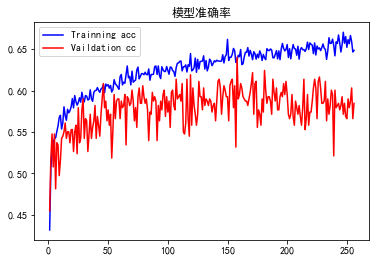

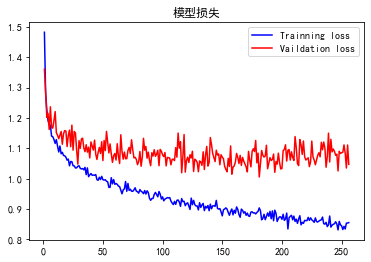

In [78]:

#########画图
mpl.rcParams['font.sans-serif'] = ['SimHei']
accuracy = history.history['accuracy']     #获取训练集准确性数据
val_accuracy = history.history['val_accuracy']    #获取验证集准确性数据
loss = history.history['loss']          #获取训练集错误值数据
val_loss = history.history['val_loss']  #获取验证集错误值数据
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,label='Trainning acc',color = 'blue')     #以epochs为横坐标，以训练集准确性为纵坐标
plt.plot(epochs,val_accuracy,label='Vaildation cc',color = 'red') #以epochs为横坐标，以验证集准确性为纵坐标
plt.legend()   #绘制图例，即标明图中的线段代表何种含义
plt.title('模型准确率')

plt.figure()   #创建一个新的图表
plt.plot(epochs,loss,label='Trainning loss',color = 'blue')
plt.plot(epochs,val_loss,label='Vaildation loss',color = 'red')
plt.legend()  ##绘制图例，即标明图中的线段代表何种含义
plt.title('模型损失')
plt.show()    #显示图表

In [80]:
print('\nTesting -------------')
list1=model.evaluate(x_test,y_test)
print(list1)



Testing -------------
12/12 [==============================] - 1s 54ms/step - loss: 1.0142 - accuracy: 0.5926
[1.0141655206680298, 0.5925925970077515]


In [81]:
pre=np.argmax(model.predict(x_test), axis=-1)
#model.predict_classes(x_test)

In [82]:
print(len(pre)==len(y_test))
y_test_1=np.argmax(y_test, axis=-1)
print(y_test_1)
print(pre)

True
[5 5 3 6 3 0 1 4 0 4 5 5 0 0 5 0 3 3 2 1 5 5 5 0 0 0 5 3 3 3 0 2 1 0 6 5 1
 1 0 0 5 5 0 0 0 3 1 1 0 0 0 1 0 0 3 0 3 1 2 0 5 2 6 0 5 3 5 1 0 4 5 0 4 5
 0 1 0 4 3 0 0 1 1 0 5 5 1 0 3 3 2 6 0 0 5 3 0 5 1 0 2 0 0 1 1 5 0 5 5 0 0
 5 6 4 3 5 2 0 1 0 3 0 1 4 5 5 1 5 0 5 6 5 0 4 3 0 6 0 4 0 5 6 6 5 0 5 3 1
 0 1 0 1 1 2 0 0 3 5 0 1 3 5 1 0 3 0 3 0 1 3 3 0 3 3 1 5 1 2 6 1 0 5 5 0 0
 0 0 0 4 0 0 1 0 5 1 1 0 6 5 5 0 6 3 5 2 6 0 2 5 0 6 0 0 5 5 0 5 3 0 5 0 5
 5 1 4 0 0 0 5 5 2 6 0 5 5 1 3 5 3 0 1 5 0 5 0 0 0 5 1 5 1 5 2 0 5 1 2 2 1
 0 5 5 3 4 0 0 0 1 0 0 1 4 0 3 0 0 1 6 2 5 0 0 5 0 3 1 0 3 2 4 0 5 0 3 2 0
 4 5 1 3 0 2 5 5 4 2 1 0 6 3 3 0 3 4 0 1 1 5 4 5 0 1 5 0 6 0 5 3 3 5 5 0 5
 6 5 2 6 6 0 3 0 1 5 5 1 0 0 5 0 5 3 0 4 0 5 0 5 3 1 5 4 3 5 2 5 3 0 6 5 2
 5 0 4 0 5 0 2 0]
[5 5 6 3 5 1 5 4 0 4 5 5 0 0 5 0 0 0 2 5 1 5 5 0 5 0 5 0 0 1 0 2 1 0 5 5 0
 1 0 1 5 1 0 0 0 0 1 1 0 1 0 5 1 5 5 6 5 0 2 0 5 2 6 0 1 5 1 5 0 3 5 0 4 5
 0 5 5 4 3 5 0 5 5 0 5 0 1 1 0 5 2 3 0 0 5 0 0 5 1 5 5 0 0 3 5 6 0 1 5 0 0
 5

In [83]:
#验证集
cnt_test=cnt_label(np.argmax(y_test, axis=-1))

[88, 25, 18, 5, 13, 61, 14]
[0.7154471544715447, 0.4807692307692308, 0.75, 0.10638297872340426, 0.6190476190476191, 0.6853932584269663, 0.6363636363636364]


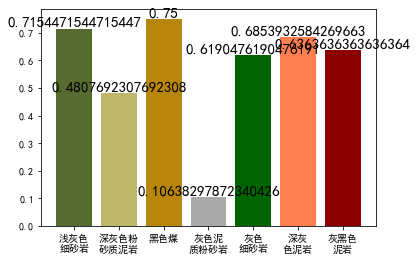

[0.7154471544715447, 0.4807692307692308, 0.75, 0.10638297872340426, 0.6190476190476191, 0.6853932584269663, 0.6363636363636364]
<class 'numpy.number'>


In [84]:
pre_cnt=[0,0,0,0,0,0,0]  #每个类别预测准确率

for i in range(len(pre)):
    if pre[i]==y_test_1[i]:
        pre_cnt[pre[i]]+=1
print(pre_cnt)
for i in range(len(pre_cnt)):        
    pre_cnt[i]=pre_cnt[i]/cnt_test[i]
print(pre_cnt)
print_count(pre_cnt)

保存训练结果

In [88]:
#数据集文件保存
import os
dir_model="D:\\_dataset\\trained_models\\VGG19_2(softmax,256epochs).h5"

if os.path.exists(dir_model)==False:
    model.save(dir_model)
    print("保存模型成功")




In [90]:
train_file="D:\\_dataset\\trained_models\\模型历史数据\\VGG19_2(softmax,256epochs).h5\\"
train_loss=train_file+"loss.txt"
train_acc=train_file+"acc.txt"
train_val_loss=train_file+"val_loss.txt"
train_val_acc=train_file+"val_acc.txt"

if os.path.exists(train_loss)==False:
    np.savetxt(train_loss, history.history['loss'], fmt="%f") 
    print("保存模型训练损失成功")
if os.path.exists(train_acc)==False:
    np.savetxt(train_acc, history.history['accuracy'], fmt="%f") 
    print("保存模型训练准确率成功")
if os.path.exists(train_val_loss)==False:
    np.savetxt(train_val_loss, history.history['val_loss'], fmt="%f") 
    print("保存模型验证损失成功")
if os.path.exists(train_val_acc)==False:
    np.savetxt(train_val_acc, history.history['val_accuracy'], fmt="%f") 
    print("保存模型验证准确率成功")

保存模型训练损失成功
保存模型训练准确率成功
保存模型验证损失成功
保存模型验证准确率成功


In [74]:
dir_dataset_file="D:\\_dataset\\trained_models\\dataset_file.txt"
if os.path.exists(dir_dataset_file)==False:
    np.savetxt(dir_dataset_file, arr, fmt="%d") #保存为整数
    print("保存数据集成功")

In [31]:
#print(arr==arr2)

In [37]:
'''
arr2=[]
with open(dir_dataset_file) as lines:
    for line in lines:
        arr2.append(eval(line))
        
#print((arr2==arr).all())'''

'\narr2=[]\nwith open(dir_dataset_file) as lines:\n    for line in lines:\n        arr2.append(eval(line))\n        \n#print((arr2==arr).all())'

In [48]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
